# Posterior test
In this notebook, you can test on any observable with an individual trained model or the stacked one. As long as you have enough test samples, you can use the test results to validate the posteriors. The diagnostics of the validation is introduced in another notebook "Diagnostics"

In [1]:
import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "7"
import numpy as np
import matplotlib.pyplot as plt
import pydelfi.priors as priors
import pydelfi.ndes as ndes
import pydelfi.delfi as delfi
import tensorflow as tf
import pickle

tf.logging.set_verbosity(tf.logging.ERROR)
config = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1, allow_soft_placement=True, device_count = {'CPU': 1})
session = tf.Session(config=config)

## Prepare the data

In [2]:
#define the parameter prior 
lower = np.array([4,1])
upper = np.array([6,2.398])
prior = priors.Uniform(lower, upper)

#validation data
theta_fiducials = np.load('data/hera_para_validation.npy')
compressed_datas = np.load('data/hera_ps_validation.npy')

#training data
sim_params = np.load('data/hera_para.npy')
sim_compressed_data=np.load('data/hera_ps.npy')

#dimension of the data summary
nd=compressed_datas.shape[1]

#0 for the faint model; 1 for the bright model
theta_fiducial = theta_fiducials[0]
compressed_data = compressed_datas[0]

#the directory to load the trained model
diri = "data/diagnostics/trained_hera/"

## Define the function for validation on a single mock observation

In [3]:
def pos(i):
   
    theta_fiducial = theta_fiducials[i]
    compressed_data = compressed_datas[i]

    NDEs = [ndes.ConditionalMaskedAutoregressiveFlow(n_parameters=2, n_data=nd, n_hiddens=[50,50], n_mades=5, act_fun=tf.tanh, index=0),
            ndes.ConditionalMaskedAutoregressiveFlow(n_parameters=2, n_data=nd, n_hiddens=[50,50], n_mades=5, act_fun=tf.tanh, index=1),
            ndes.ConditionalMaskedAutoregressiveFlow(n_parameters=2, n_data=nd, n_hiddens=[50,50], n_mades=5, act_fun=tf.tanh, index=2),
            ndes.ConditionalMaskedAutoregressiveFlow(n_parameters=2, n_data=nd, n_hiddens=[50,50], n_mades=5, act_fun=tf.tanh, index=3)]
    

    DelfiEnsemble = delfi.Delfi(compressed_data, prior, NDEs, 
                            Finv = None,
                            n_procs = 1,
                            theta_fiducial = theta_fiducial, 
                            param_limits = [lower, upper],
                            param_names = ['\mathrm{log_{10}\,T_{vir}}', '\mathrm{log_{10}\,\zeta}'], 
                            results_dir = diri,
                            progress_bar = False,
                            save = False,
                            restore = True,
                            input_normalization=None)

    
    posterior_samples = DelfiEnsemble.emcee_sample(burn_in_chain=600, main_chain=1000)
    with open('data/posterior_samples/po_validate_%d.pkl'%i, 'wb') as f:
        pickle.dump(posterior_samples,f)
  

## Validate on a pre-set number of observations

In [4]:
%%time
#can validate on different mock observations; better to run in parallel
#for i in range(len(compressed_datas)):
for i in range(1):
    pos(i)

CPU times: user 4min 27s, sys: 4.07 s, total: 4min 31s
Wall time: 4min 28s


## Plot the results

Removed no burn in
Removed no burn in
Removed no burn in


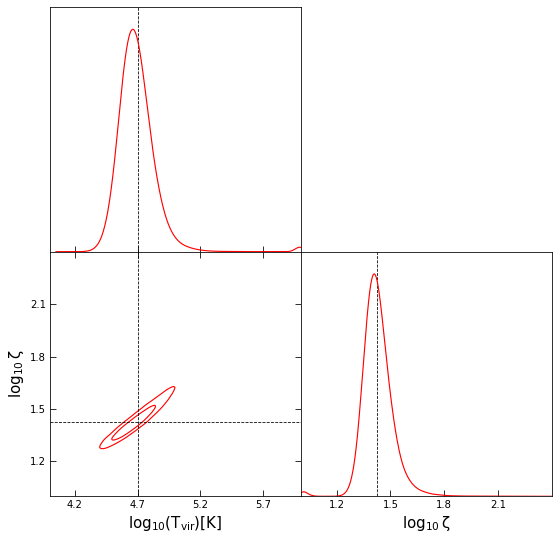

<Figure size 288x216 with 0 Axes>

In [10]:
%matplotlib inline
from getdist import plots, MCSamples
import getdist

param_names = ['$\mathrm{log_{10}(T_{vir})[K]}$', '$\mathrm{log_{10}\,\zeta}$']

def plots_all(d_all,colorl,colorx):
    sample1 = MCSamples(samples=[d_all[:,0]],names = [param_names[0]], labels = param_names[0])
    sample2 = MCSamples(samples=[d_all[:,1]],names = [param_names[1]], labels = param_names[1])
    g.add_1d(sample1,param_names[0], ax=ax[0,0], color=colorl)
    g.add_1d(sample2,param_names[1], ax=ax[1,1], color=colorl)
    sample12 = MCSamples(samples=d_all,names = param_names, labels = param_names)
    con1 = g.add_2d_contours(sample12, param_names[0], param_names[1], ax=ax[1,0], color=colorl, filled = False,contour_levels=[0.32,0.05])

for num in range(1):
    fig, ax = plt.subplots(figsize=(9,9),nrows=2, ncols=2, gridspec_kw={'hspace': 0, 'wspace': 0})
    ax[0,0].set_yticks([])
    ax[0,0].set_xlim(4,6)
    ax[0,0].set_ylim(0,1.1)
    ax[0,0].axvline(theta_fiducial[0], linestyle='--', c = 'k', lw = .8)
    ax[0,0].set_xticks([4.2, 4.7, 5.2, 5.7])
    ax[0,0].tick_params(axis = 'x', top = False, direction = "in", length = 6)
    
    ax[0,1].set(frame_on=False)
    ax[0,1].set_yticks([])
    ax[0,1].set_xticks([])
    ax[1,0].set_xlim(4,6)
    ax[1,0].set_ylim(1,2.4)
    ax[1,0].set_xticks([4.2, 4.7, 5.2, 5.7])
    ax[1,0].set_yticks([1.2, 1.5, 1.8, 2.1])
    
    ax[1,0].tick_params(axis = 'both', top = True, right = True, direction = "in", length = 6)
    ax[1,0].axvline(theta_fiducial[0], linestyle = '--', c = 'k', lw = .8)
    ax[1,0].axhline(theta_fiducial[1], linestyle = '--', c = 'k', lw = .8)
    ax[1,0].set_xlabel("$\mathrm{log_{10}(T_{vir})[K]}$",fontsize=15)
    ax[1,0].set_ylabel("$\mathrm{log_{10}\,\zeta}$",fontsize=15)
    ax[1,1].set_yticks([])
    ax[1,1].set_xlim(1,2.4)
    ax[1,1].set_ylim(0,1.1)
    ax[1,1].set_xticks([1.2, 1.5, 1.8, 2.1])
    ax[1,1].tick_params(axis = 'x', top = False, direction = "in", length = 6)
    ax[1,1].axvline(theta_fiducial[1], linestyle = '--', c = 'k', lw = .8)
    ax[1,1].set_xlabel("$\mathrm{log_{10}\,\zeta}$",fontsize=15)
    
    g = plots.getSinglePlotter(width_inch=4)
    f = open("data/posterior_samples/po_validate_%d.pkl"%num, 'rb')
    d = pickle.load(f)
    sample=np.unique(d[0], axis=0, return_counts=False)
    plots_all(sample,'red','red')